In [1]:
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import time

import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

from utils_cifar10 import *
from models import GoogLeNet

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
transform_train = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
batch_size = 64

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
print(trainset.data.shape)
print(type(trainset.data))
print(type(trainset))

(50000, 32, 32, 3)
<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


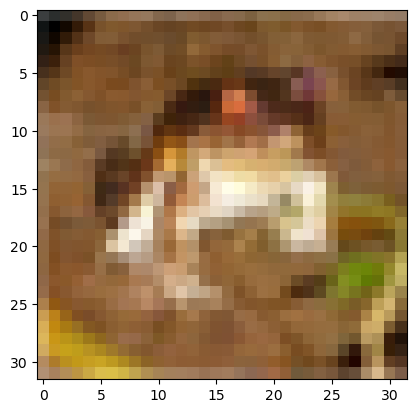

In [9]:
plt.imshow(trainset.data[0])
im,label = next(iter(trainloader))

In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

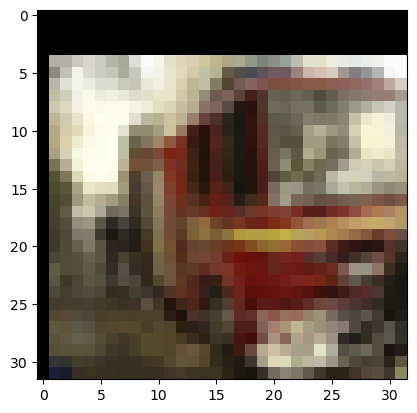

In [11]:
im[0].shape
imshow(im[0])

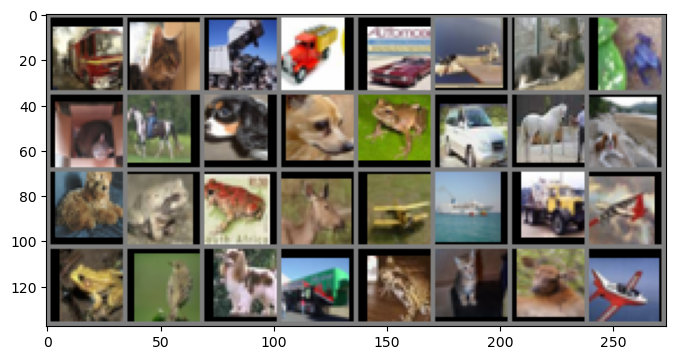

In [12]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

In [33]:
def train(net, trainloader, testloader, epoches, optimizer , criterion , scheduler=None):
    best_acc = 0
    train_acc_list, test_acc_list = [],[]
    train_loss_list, test_loss_list = [],[]
    lr_list = []
    for i in range(epoch):
        start = time.time()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            logits, aux_logits2, aux_logits1 = net(im)
            loss0 = criterion(logits, label)
            loss1 = criterion(aux_logits1, label)
            loss2 = criterion(aux_logits2, label)
            loss = loss0 + loss1 *0.3 + loss2* 0.3
            loss.backward()
            optimizer.step()
            outputs = logits
            train_loss += loss.data
            probs, pred_y = outputs.data.max(dim=1) # get the probability
            train_acc += (pred_y==label).sum()/label.size(0)
    
            rate = (step + 1) / len(trainloader)
            a = "*"* int(rate *50)
            b = "."* (50 - int(rate *50))
            print('\r train {:3d}|{:3d} {:^3.0f}% [{}->{}] '.format(i+1,epoch,int(rate*100),a ,b),end='')
    

        if scheduler:
            scheduler.step(train_loss)
        
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc*100 / len(trainloader)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        lr = optimizer.param_groups[0]['lr']
        lr_list.append(lr)
        
        
        
        net.eval()
        with torch.no_grad():
            for step,data in enumerate(testloader,start=0):
                im,label = data
                im = im.to(device)
                label = label.to(device)
                outputs = net(im)
                loss = criterion(outputs,label)
                test_loss += loss.data
                probs, pred_y = outputs.data.max(dim=1) # get the probability
                test_acc += (pred_y==label).sum()/label.size(0)
                rate = (step + 1) / len(testloader)
                a = "*" *int(rate* 50)
                b = "." *(50 - int(rate* 50))
                print('\r test {:3d}|{:3d} {:^3.0f}% [{}->{}] '.format(i+1,epoch,int(rate*100),a ,b),end='')
        test_loss = test_loss / len(testloader)
        test_acc = test_acc* 100 /len(testloader)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)
        end = time.time()
        print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                        i + 1, epoch, train_loss, train_acc, test_loss, test_acc,lr), end='')
        time_= int(end - start)
        time_ = int(end - start)
        h = time_/ 3600
        m = time_% 3600/60
        s = time_% 60
        time_str = "\tTime %02d:%02d" % ( m, s)
        # print elapsed time
        print(time_str)
    
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['test_acc'] = test_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['test_loss'] = test_loss_list
    Lr = lr_list

    return Acc, Loss, Lr

In [14]:
net = GoogLeNet(3, 10, aux_logits=True).to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [15]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
       BasicConv2d-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]           4,160
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
       BasicConv2d-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 192, 8, 8]         110,784
      BatchNorm2d-11            [-1, 192, 8, 8]             384
             ReLU-12            [-1, 192, 8, 8]               0
      BasicConv2d-13            [-1, 192, 8, 8]               0
        MaxPool2d-14            [-1, 19

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [16]:
epoch = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, min_lr=1e-5) 

In [17]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler)

Epoch [  1/ 50]  Train Loss:3.218323  Train Acc:32.37% Test Loss:2.025806  Test Acc:43.68%  Learning Rate:0.010000	Time 00:48
Epoch [  2/ 50]  Train Loss:2.590827  Train Acc:45.10% Test Loss:1.903158  Test Acc:49.55%  Learning Rate:0.010000	Time 00:48
Epoch [  3/ 50]  Train Loss:2.185021  Train Acc:53.23% Test Loss:1.172637  Test Acc:57.97%  Learning Rate:0.010000	Time 00:49
Epoch [  4/ 50]  Train Loss:1.878747  Train Acc:60.22% Test Loss:0.988015  Test Acc:64.84%  Learning Rate:0.010000	Time 00:46
Epoch [  5/ 50]  Train Loss:1.686332  Train Acc:64.92% Test Loss:0.925754  Test Acc:68.12%  Learning Rate:0.010000	Time 00:46
Epoch [  6/ 50]  Train Loss:1.540813  Train Acc:68.28% Test Loss:0.865997  Test Acc:69.83%  Learning Rate:0.010000	Time 00:46
Epoch [  7/ 50]  Train Loss:1.437360  Train Acc:70.57% Test Loss:0.817418  Test Acc:71.91%  Learning Rate:0.010000	Time 00:48
Epoch [  8/ 50]  Train Loss:1.356502  Train Acc:72.27% Test Loss:0.741778  Test Acc:74.24%  Learning Rate:0.010000	Tim

In [18]:
train_loss, test_loss = Loss['train_loss'], Loss['test_loss']
train_acc, test_acc = Acc['train_acc'], Acc['test_acc']
train_loss = [i.to('cpu') for i in train_loss]
test_loss = [i.to('cpu') for i in test_loss]
train_acc = [i.to('cpu') for i in train_acc]
test_acc = [i.to('cpu') for i in test_acc]
Acc['train_acc'] = train_acc
Acc['test_acc'] = test_acc
Loss['train_loss'] = train_loss
Loss['test_loss'] = test_loss

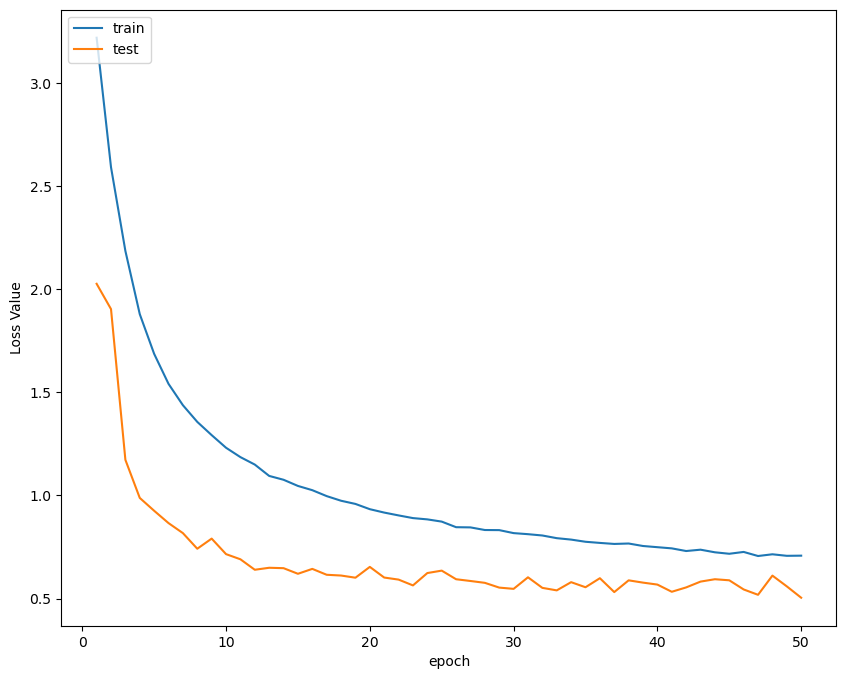

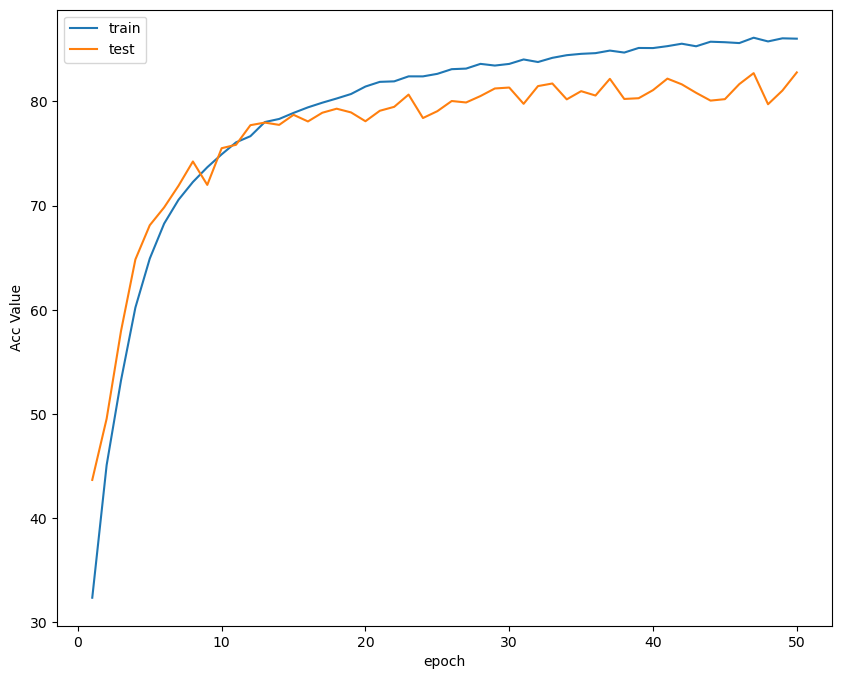

In [19]:
plot_history(epoch, Acc, Loss)

In [20]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 82.80 %


In [21]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 80.00 %
Accuracy of automobile : 88.60 %
Accuracy of  bird : 77.50 %
Accuracy of   cat : 68.70 %
Accuracy of  deer : 79.60 %
Accuracy of   dog : 74.80 %
Accuracy of  frog : 91.30 %
Accuracy of horse : 89.00 %
Accuracy of  ship : 92.00 %
Accuracy of truck : 86.50 %


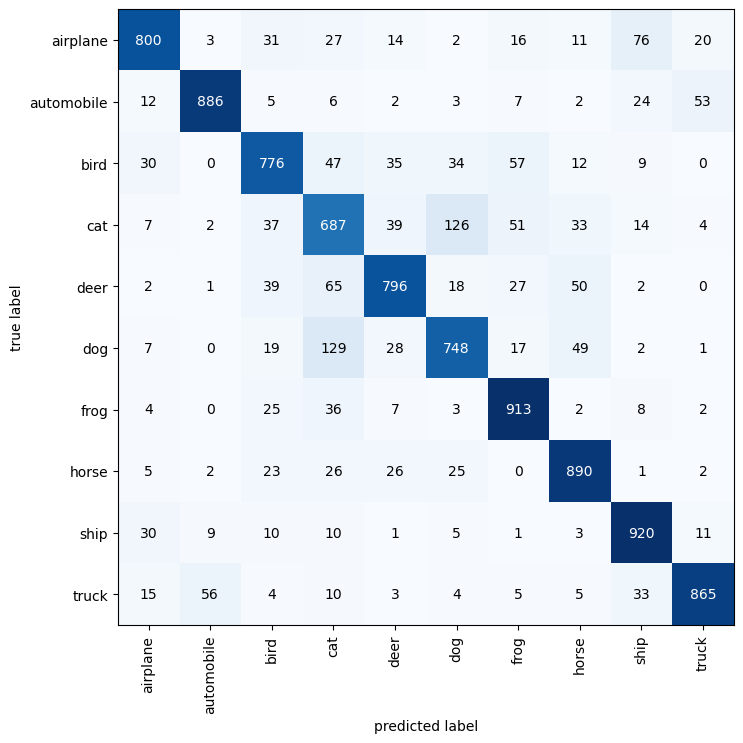

In [22]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net.to('cpu'), data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 82.8125%


<Figure size 2500x400 with 0 Axes>

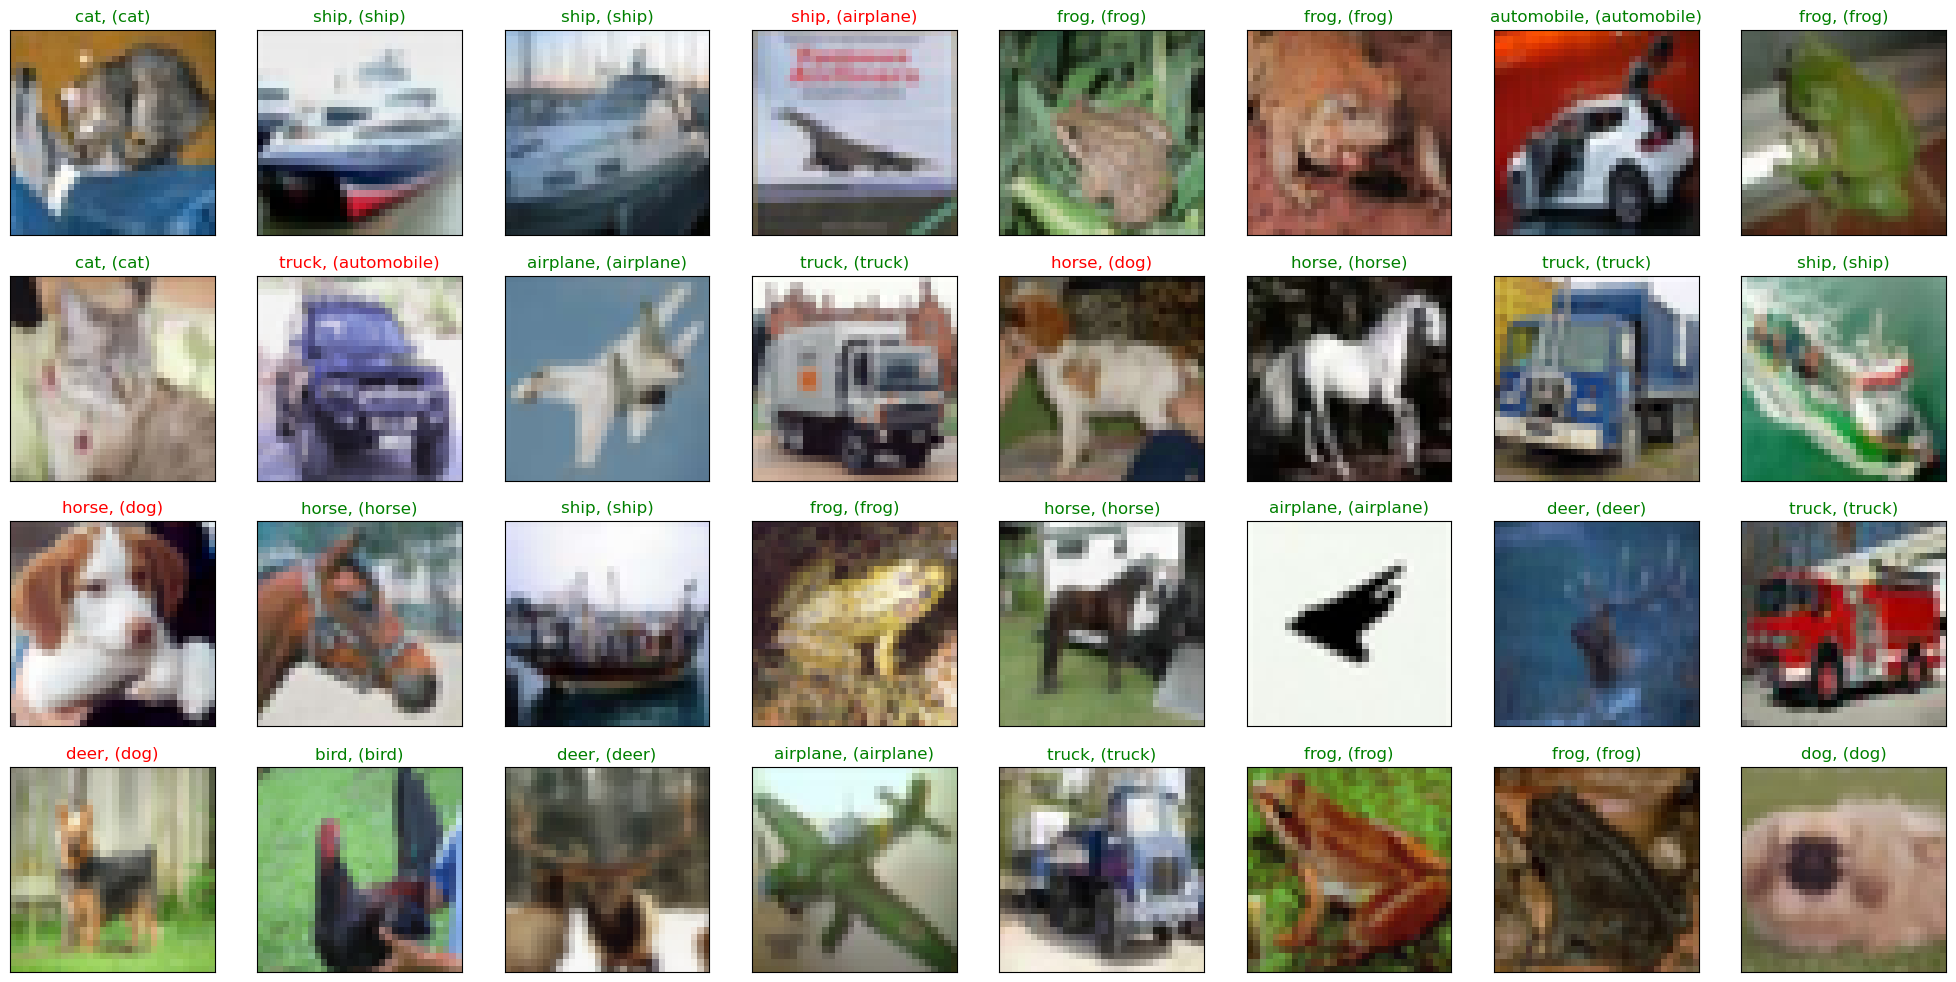

In [27]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to('cpu')
labels = labels.to('cpu')
val_output = net(images_).to('cpu')
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

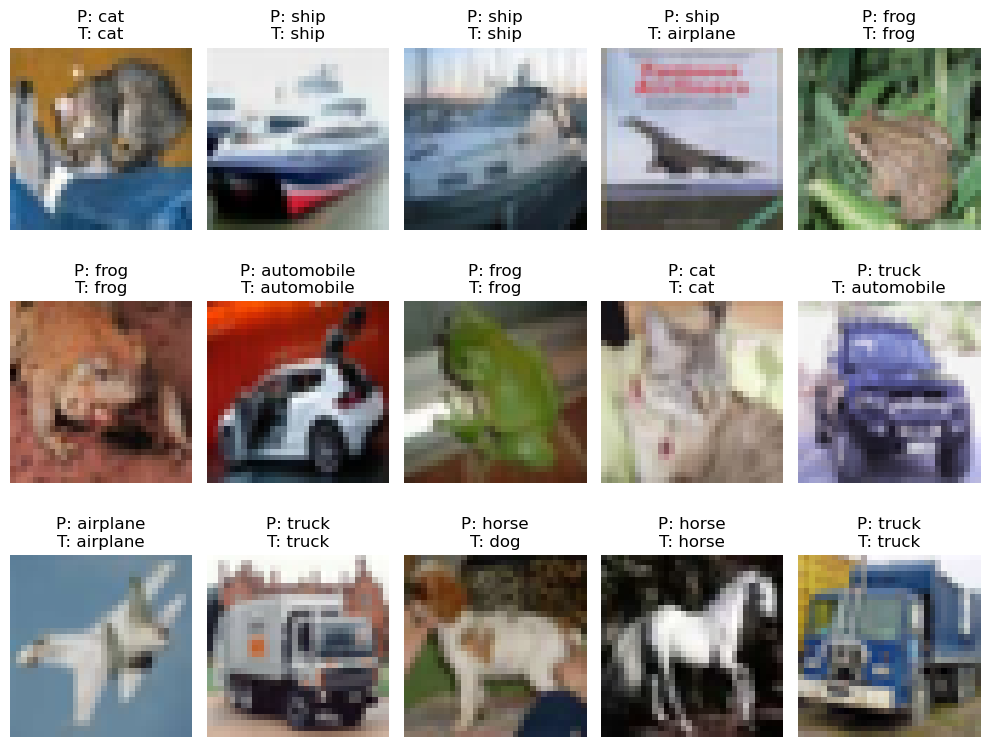

In [28]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## GoodLeNet Adam

In [34]:
net = GoogLeNet(3, 10, aux_logits=True).to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [35]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
       BasicConv2d-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]           4,160
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
       BasicConv2d-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 192, 8, 8]         110,784
      BatchNorm2d-11            [-1, 192, 8, 8]             384
             ReLU-12            [-1, 192, 8, 8]               0
      BasicConv2d-13            [-1, 192, 8, 8]               0
        MaxPool2d-14            [-1, 19

In [36]:
epoch = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [37]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion)

Epoch [  1/ 50]  Train Loss:2.655188  Train Acc:39.53% Test Loss:1.445688  Test Acc:48.37%  Learning Rate:0.001000	Time 00:53
Epoch [  2/ 50]  Train Loss:2.021279  Train Acc:56.08% Test Loss:1.005961  Test Acc:64.05%  Learning Rate:0.001000	Time 00:52
Epoch [  3/ 50]  Train Loss:1.717428  Train Acc:63.16% Test Loss:0.939729  Test Acc:67.88%  Learning Rate:0.001000	Time 00:55
Epoch [  4/ 50]  Train Loss:1.543060  Train Acc:67.81% Test Loss:0.807159  Test Acc:72.69%  Learning Rate:0.001000	Time 00:56
Epoch [  5/ 50]  Train Loss:1.400755  Train Acc:70.90% Test Loss:0.756670  Test Acc:74.68%  Learning Rate:0.001000	Time 00:54
Epoch [  6/ 50]  Train Loss:1.300270  Train Acc:73.46% Test Loss:0.720163  Test Acc:75.31%  Learning Rate:0.001000	Time 00:54
Epoch [  7/ 50]  Train Loss:1.218234  Train Acc:75.23% Test Loss:0.660986  Test Acc:77.43%  Learning Rate:0.001000	Time 00:55
Epoch [  8/ 50]  Train Loss:1.158733  Train Acc:76.40% Test Loss:0.632067  Test Acc:78.28%  Learning Rate:0.001000	Tim

In [38]:
train_loss, test_loss = Loss['train_loss'], Loss['test_loss']
train_acc, test_acc = Acc['train_acc'], Acc['test_acc']
train_loss = [i.to('cpu') for i in train_loss]
test_loss = [i.to('cpu') for i in test_loss]
train_acc = [i.to('cpu') for i in train_acc]
test_acc = [i.to('cpu') for i in test_acc]
Acc['train_acc'] = train_acc
Acc['test_acc'] = test_acc
Loss['train_loss'] = train_loss
Loss['test_loss'] = test_loss

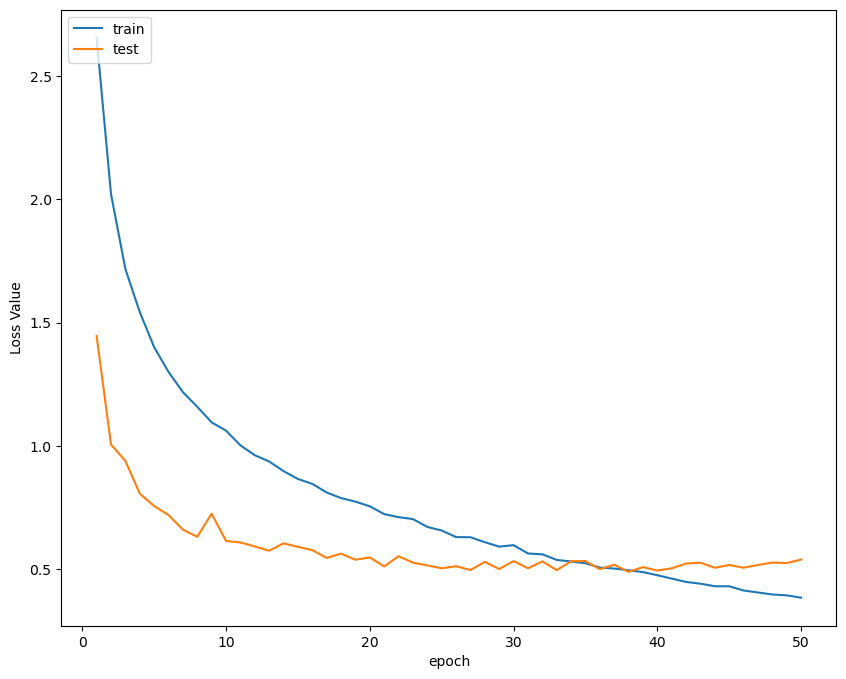

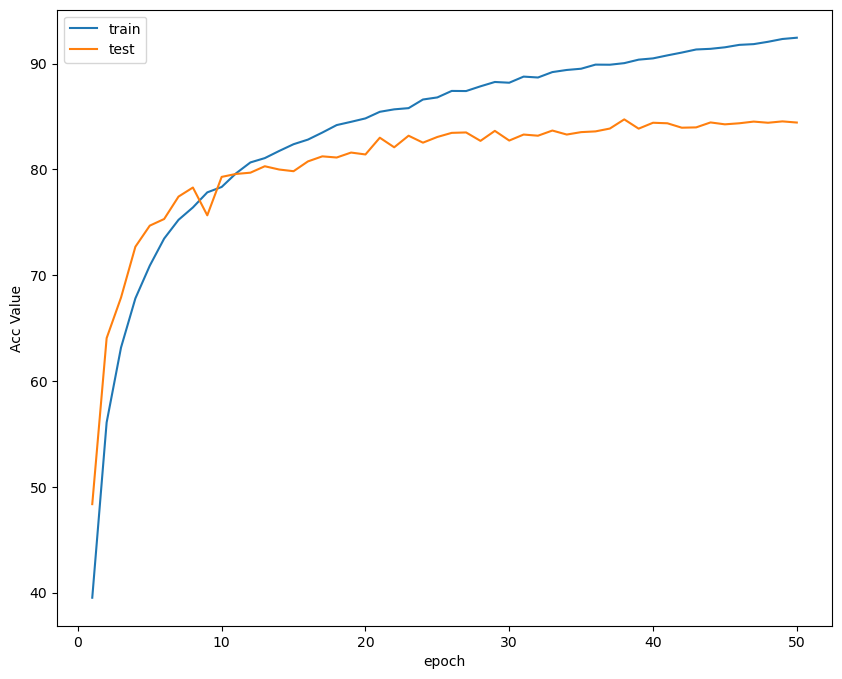

In [39]:
plot_history(epoch ,Acc, Loss)

In [40]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 84.44 %


In [41]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 89.20 %
Accuracy of automobile : 90.30 %
Accuracy of  bird : 80.70 %
Accuracy of   cat : 65.70 %
Accuracy of  deer : 83.00 %
Accuracy of   dog : 75.50 %
Accuracy of  frog : 91.60 %
Accuracy of horse : 88.00 %
Accuracy of  ship : 92.00 %
Accuracy of truck : 88.40 %


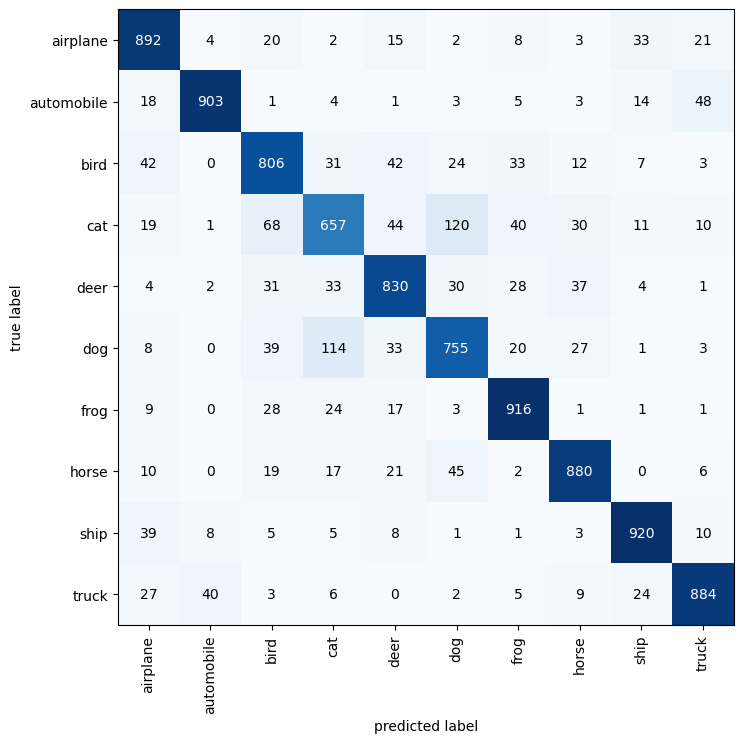

In [42]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net.to('cpu'), data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 87.5%


<Figure size 2500x400 with 0 Axes>

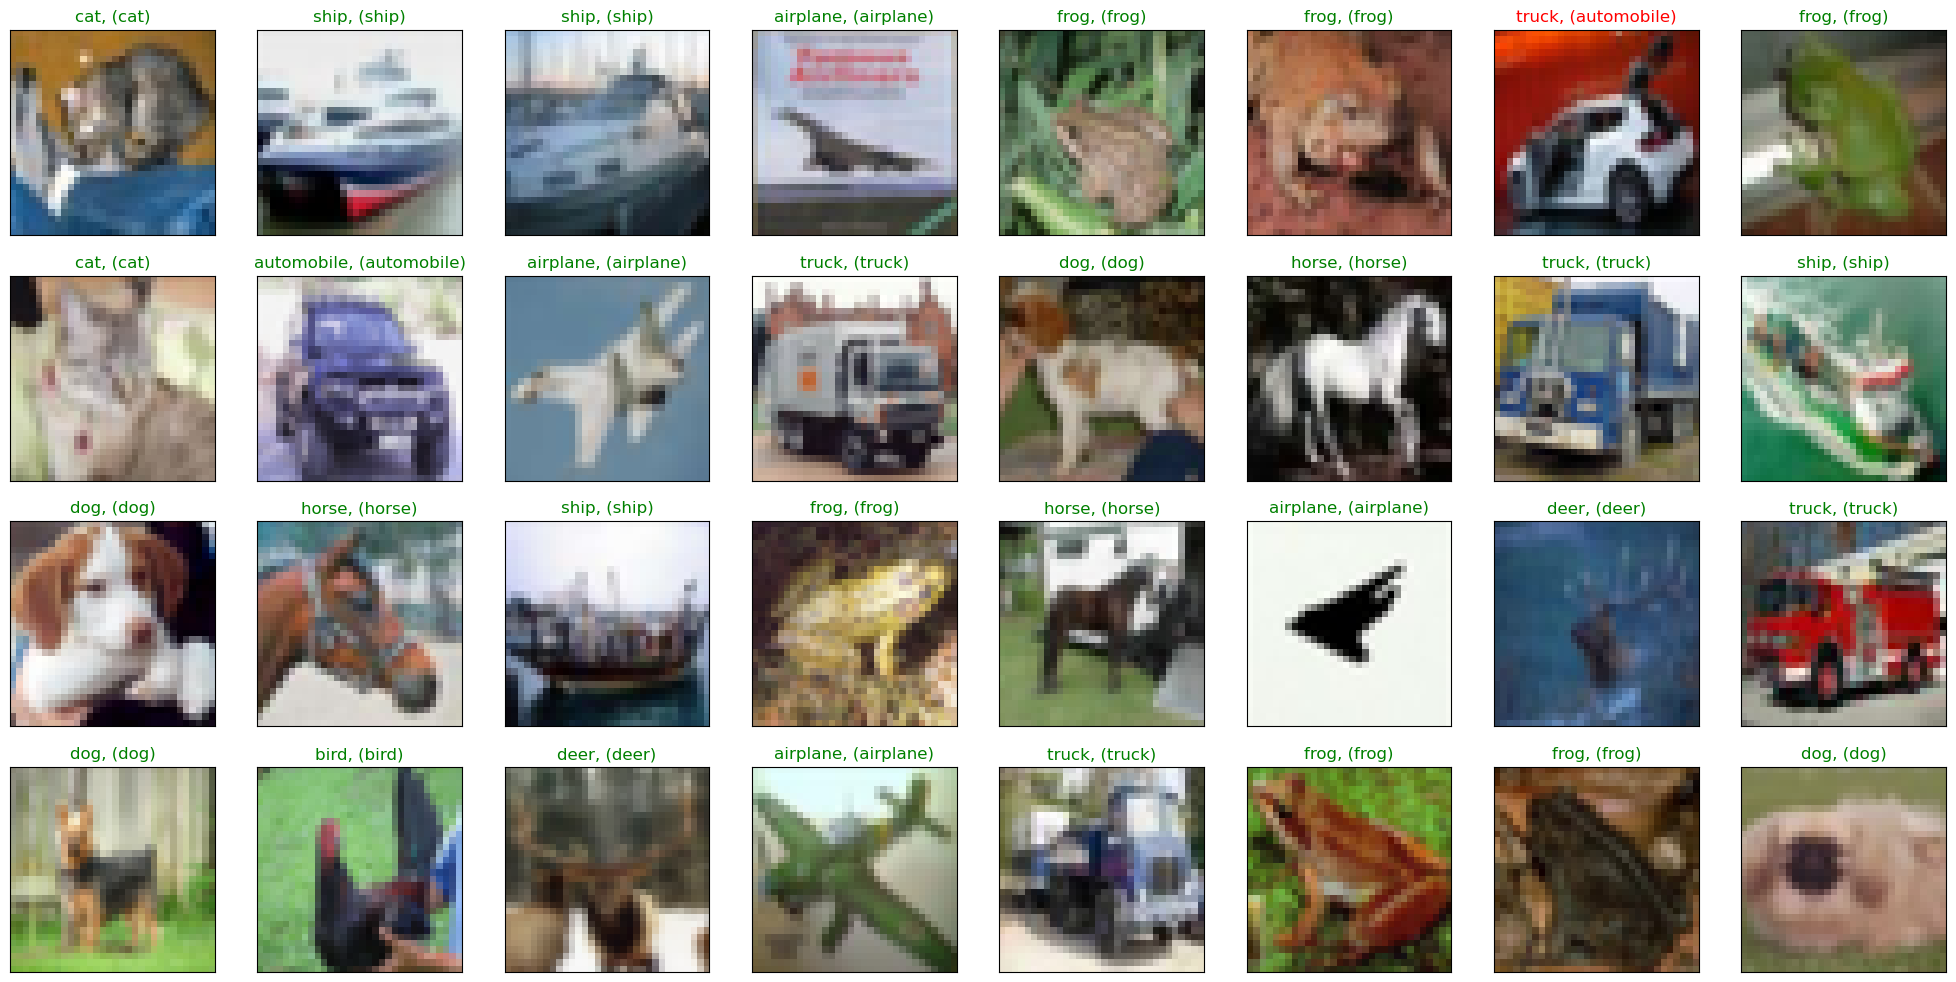

In [46]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to('cpu')
labels = labels.to('cpu')
val_output = net(images_).to('cpu')
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

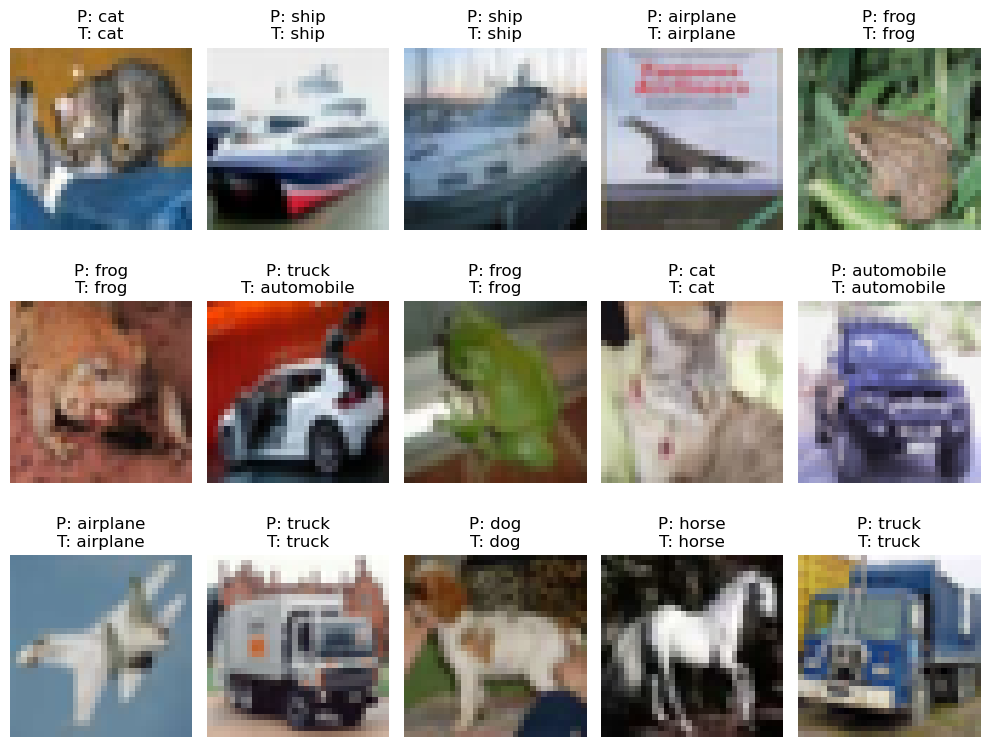

In [47]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)